<a href="https://colab.research.google.com/github/ptaceda/mrtva_doba_VU/blob/main/zpracovani_vysledku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
### SPUSTIT TOHLE NA PC PŘED PRACÍ !!

import os
import sys

# Set the working directory to the project directory
device = input("Zadej prosím, na jakém zařízení děláš (mac/doma/prace): ")
if device == "doma":
    project_dir = r"C:/Users/danie/Desktop/mrtva_doba_VU"
    os.chdir(project_dir)
elif device == "mac":
    project_dir = r"/Users/danielptacek/Desktop/mrtva_doba_VU"
    os.chdir(project_dir)
else:
    project_dir = r"U:/Dokumenty/mrtva_doba_VU"
    os.chdir(project_dir)


# Verify the change
print("Current working directory:", os.getcwd()) 

# Ensure the project directory is in sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

import pydicom # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import os
from glob import glob
import sys

from codes.custom_library import Graf_1_2

aktivity = {
    "20240708" : 700.589,
    "20240709" : 640.979,
    "20240710" : 586.294,
    "20240711" : 537.692,
    "20240712" : 495.958,
    "20240714" : 404.370,
    "20240715" : 379.365,
    "20240717" : 324.319,
    "20240719" : 266.596,
    "20240721" : 226.576,
    "20240723" : 190.942,
    "20240725" : 158.536,
    "20240726" : 152.496,
    "20240729" : 115.038,
    "20240731" : 93.633,
    "20240805" : 62.613,
    "20240808" : 49.233,
    "20240812" : 34.167,
    "20240815" : 26.602,
    "20240819" : 18.401
}


Current working directory: /Users/danielptacek/Desktop/mrtva_doba_VU


0
1
2
3


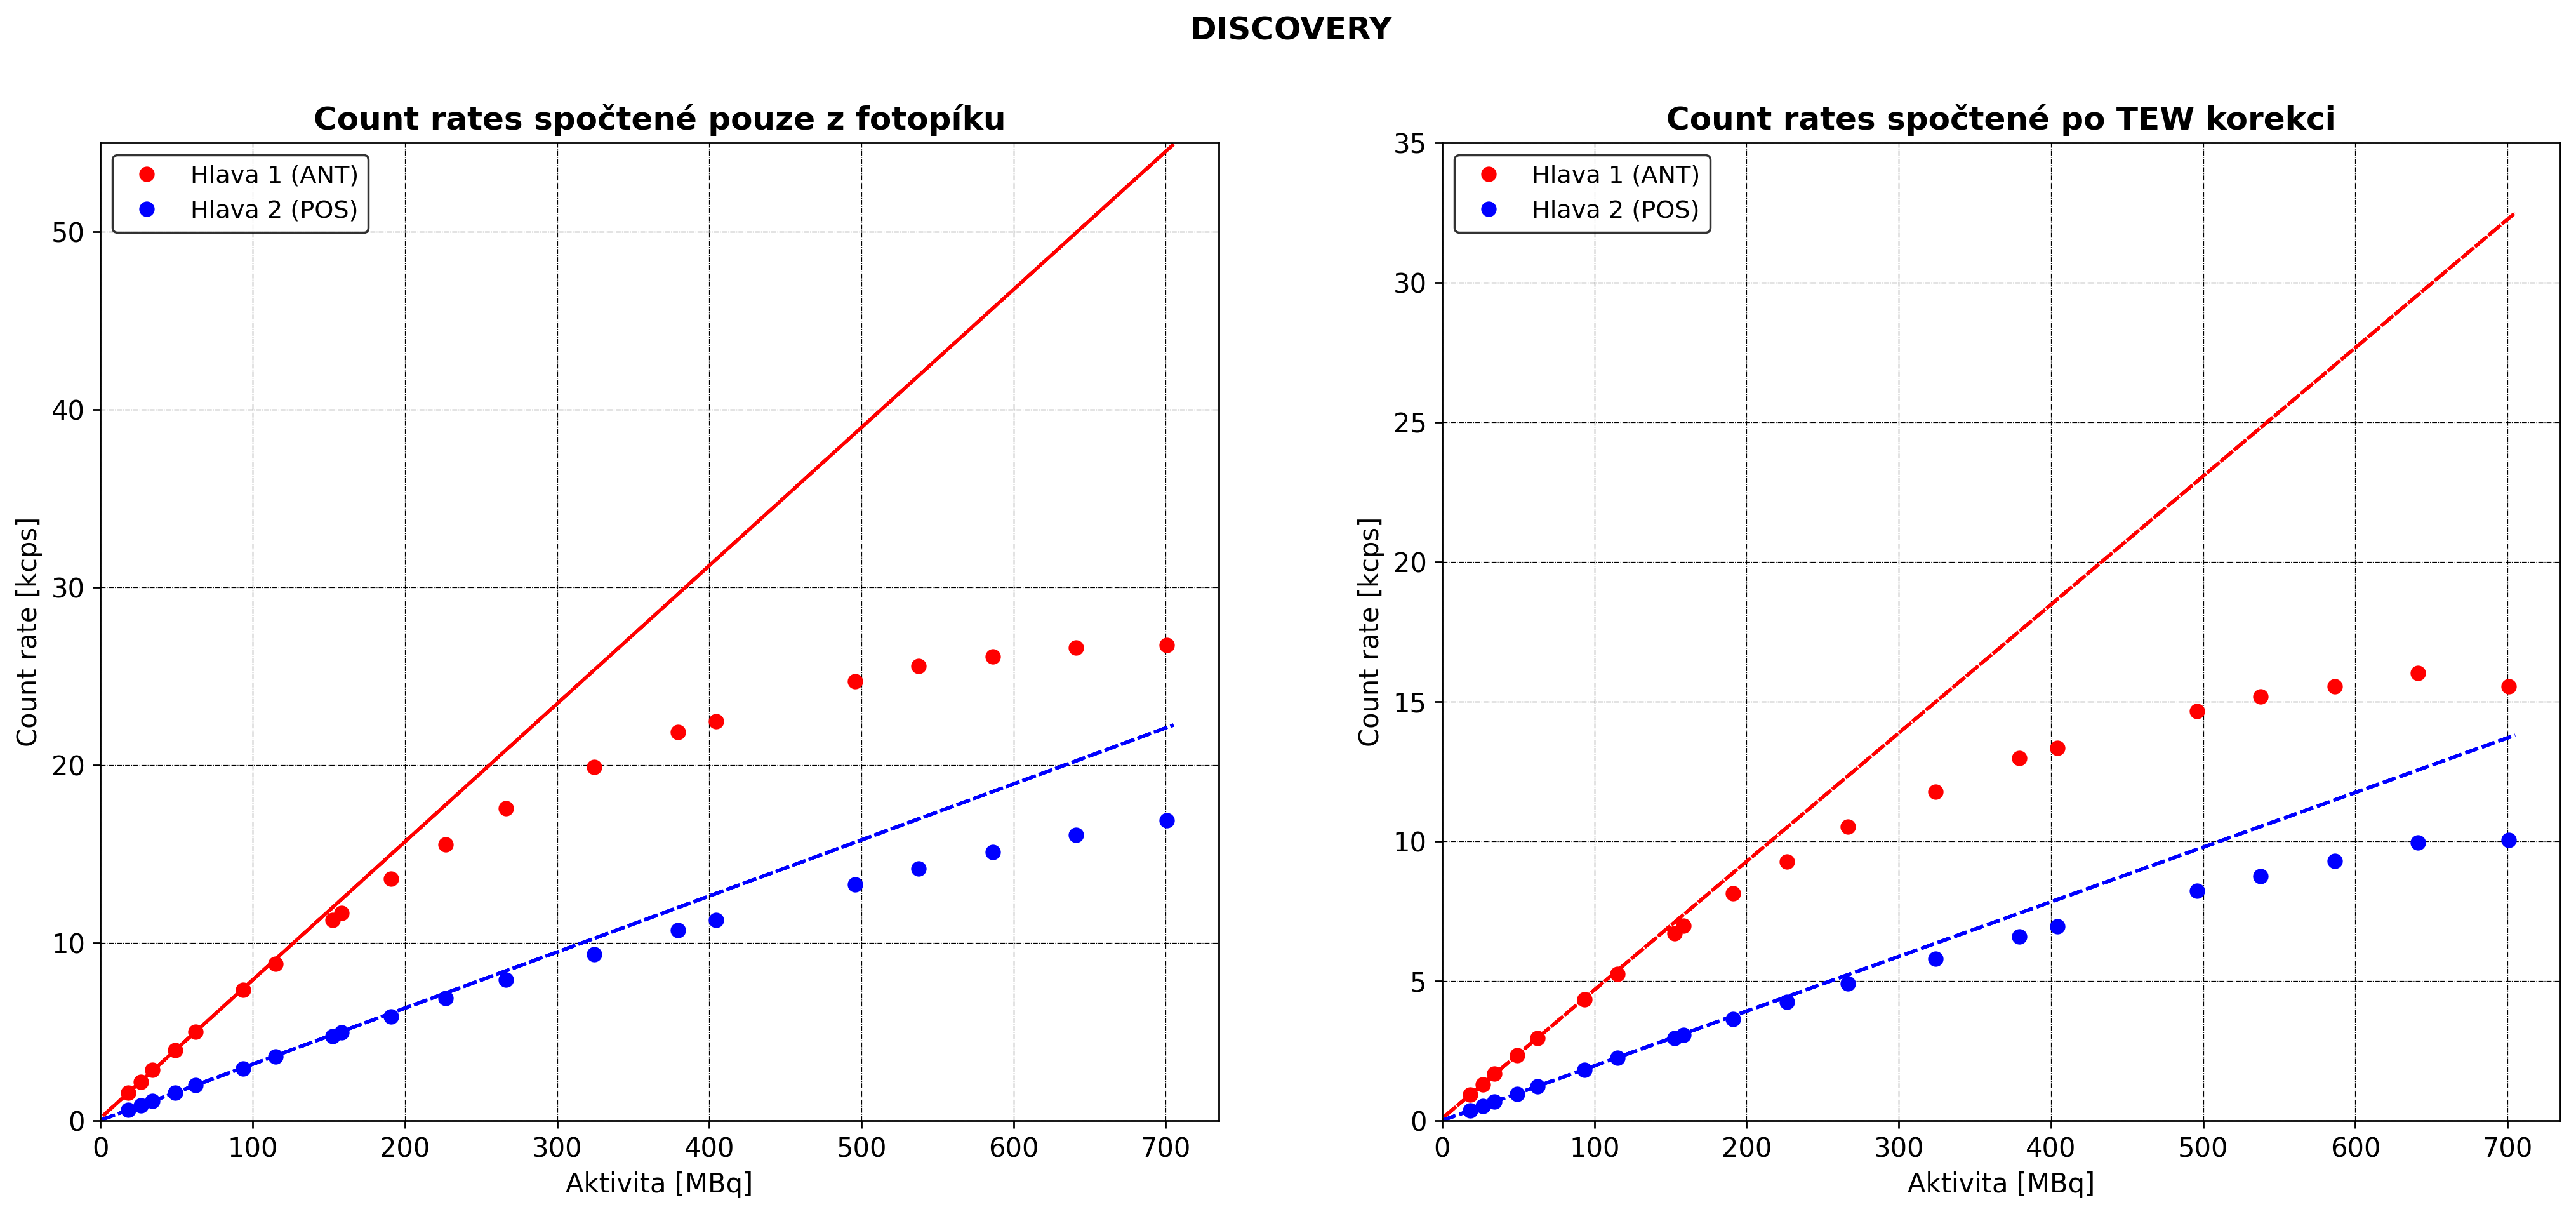

In [14]:
# DISCOVERY DATA mrtve doby

from dicom_file_separator import separate_dicom_file
from tew_correction import tew_correction
from vyber_dat_pro_fit import vyber_dat_pro_lin_fit
from fitovani import linearni_fit, linearni_fce
import numpy as np
from lmfit import Model


discovery_folder = 'Discovery'
discovery_mds = sorted(glob(os.path.join(discovery_folder, 'MD*')))

# je nutne si preddefinovat obrazek predem
dt_fig = Graf_1_2(12, "DISCOVERY",
               "Count rates spočtené pouze z fotopíku", "Aktivita [MBq]", "Count rate [kcps]",
               "Count rates spočtené po TEW korekci", "Aktivita [MBq]", "Count rate [kcps]",
               (20, 8))

# arraye pro doplňování Countrates
cr_1_no_corr_array = []
cr_2_no_corr_array = []
cr_1_tew_corr_array = []
cr_2_tew_corr_array = []

for md in discovery_mds:
    ### nejprve rozhazeni jednotlivych dat
    dead_time_path = glob(os.path.join(md, 'MD_*.dcm'))[0]
    pozadi_path = glob(os.path.join(md, 'Pozadi_*.dcm'))[0]

    dt_data = separate_dicom_file(dead_time_path)
    bg_data = separate_dicom_file(pozadi_path)

    dt_acq_time = dt_data["Acq_time"]
    bg_acq_time = bg_data["Acq_time"]
    datum = dt_data["Acq_date"]
    aktivita = aktivity[datum]

    dt_1_no_corr = dt_data["Head1_EM"]
    bg_1_no_corr = bg_data["Head1_EM"]

    dt_1_tew_corr = tew_correction(dt_data["Head1_EM"], dt_data["Head1_SC1"], dt_data["Head1_SC2"])
    bg_1_tew_corr = tew_correction(bg_data["Head1_EM"], bg_data["Head1_SC1"], bg_data["Head1_SC2"])

    dt_2_no_corr = dt_data["Head2_EM"]
    bg_2_no_corr = bg_data["Head2_EM"]
    
    dt_2_tew_corr = tew_correction(dt_data["Head2_EM"], dt_data["Head2_SC1"], dt_data["Head2_SC2"])
    bg_2_tew_corr = tew_correction(bg_data["Head2_EM"], bg_data["Head2_SC1"], bg_data["Head2_SC2"])

    ### ----
    ### vypocty count rates

    cr_1_no_corr = np.sum(dt_1_no_corr)/dt_acq_time - np.sum(bg_1_no_corr)/bg_acq_time
    cr_1_no_corr_array.append(cr_1_no_corr*0.001)

    cr_2_no_corr = np.sum(dt_2_no_corr)/dt_acq_time - np.sum(bg_2_no_corr)/bg_acq_time
    cr_2_no_corr_array.append(cr_2_no_corr*0.001)

    cr_1_tew_corr = np.sum(dt_1_tew_corr)/dt_acq_time - np.sum(bg_1_tew_corr)/bg_acq_time
    cr_1_tew_corr_array.append(cr_1_tew_corr*0.001)

    cr_2_tew_corr = np.sum(dt_2_tew_corr)/dt_acq_time - np.sum(bg_2_tew_corr)/bg_acq_time
    cr_2_tew_corr_array.append(cr_2_tew_corr*0.001)

### ----
### vyploteni do obrazku
dt_fig.fig[0].plot(aktivity.values(), cr_1_no_corr_array, "o", color = "red", label = "Hlava 1 (ANT)")
dt_fig.fig[0].plot(aktivity.values(), cr_2_no_corr_array, "o", color = "blue", label = "Hlava 2 (POS)")
dt_fig.fig[0].legend(loc = 'best', edgecolor = 'black', fontsize = 11)
dt_fig.fig[0].set_xlim(0,None)
dt_fig.fig[0].set_ylim(0,55)

dt_fig.fig[1].plot(aktivity.values(), cr_1_tew_corr_array, "o", color = "red", label = "Hlava 1 (ANT)")
dt_fig.fig[1].plot(aktivity.values(), cr_2_tew_corr_array, "o", color = "blue", label = "Hlava 2 (POS)")
dt_fig.fig[1].legend(loc = 'best', edgecolor = 'black', fontsize = 11)
dt_fig.fig[1].set_xlim(0,None)
dt_fig.fig[1].set_ylim(0,35)



lin_cr_1_no_corr = vyber_dat_pro_lin_fit(aktivity.values(), cr_1_no_corr_array)
lin_cr_1_tew_corr = vyber_dat_pro_lin_fit(aktivity.values(), cr_1_tew_corr_array)
lin_cr_2_no_corr = vyber_dat_pro_lin_fit(aktivity.values(), cr_2_no_corr_array)
lin_cr_2_tew_corr = vyber_dat_pro_lin_fit(aktivity.values(), cr_2_tew_corr_array)

data_pro_lin_fit = [lin_cr_1_no_corr, lin_cr_1_tew_corr, lin_cr_2_no_corr, lin_cr_2_tew_corr]
i = 0
for data in data_pro_lin_fit:
    akt = np.linspace(data[-1],705,5)
    fit = linearni_fit(data)
    a = fit[0]
    if i == 0:
        print(i)
        dt_fig.fig[0].plot(akt, linearni_fce(akt,a), "--", color = "red")
        i += 1
    elif i == 1:
        print(i)
        dt_fig.fig[1].plot(akt, linearni_fce(akt,a), "--", color = "red")
        i += 1
    elif i == 2:
        print(i)
        dt_fig.fig[0].plot(akt, linearni_fce(akt,a), "--", color = "blue")
        i += 1
    else:
        print(i)
        dt_fig.fig[1].plot(akt, linearni_fce(akt,a), "--", color = "blue")
        i += 1

dt_fig.Figure.savefig(os.path.join(discovery_folder, 'grafy_mrtve_doby_Discovery.jpg'), bbox_inches = "tight")

0.012039207374945696
0.016155676753160642


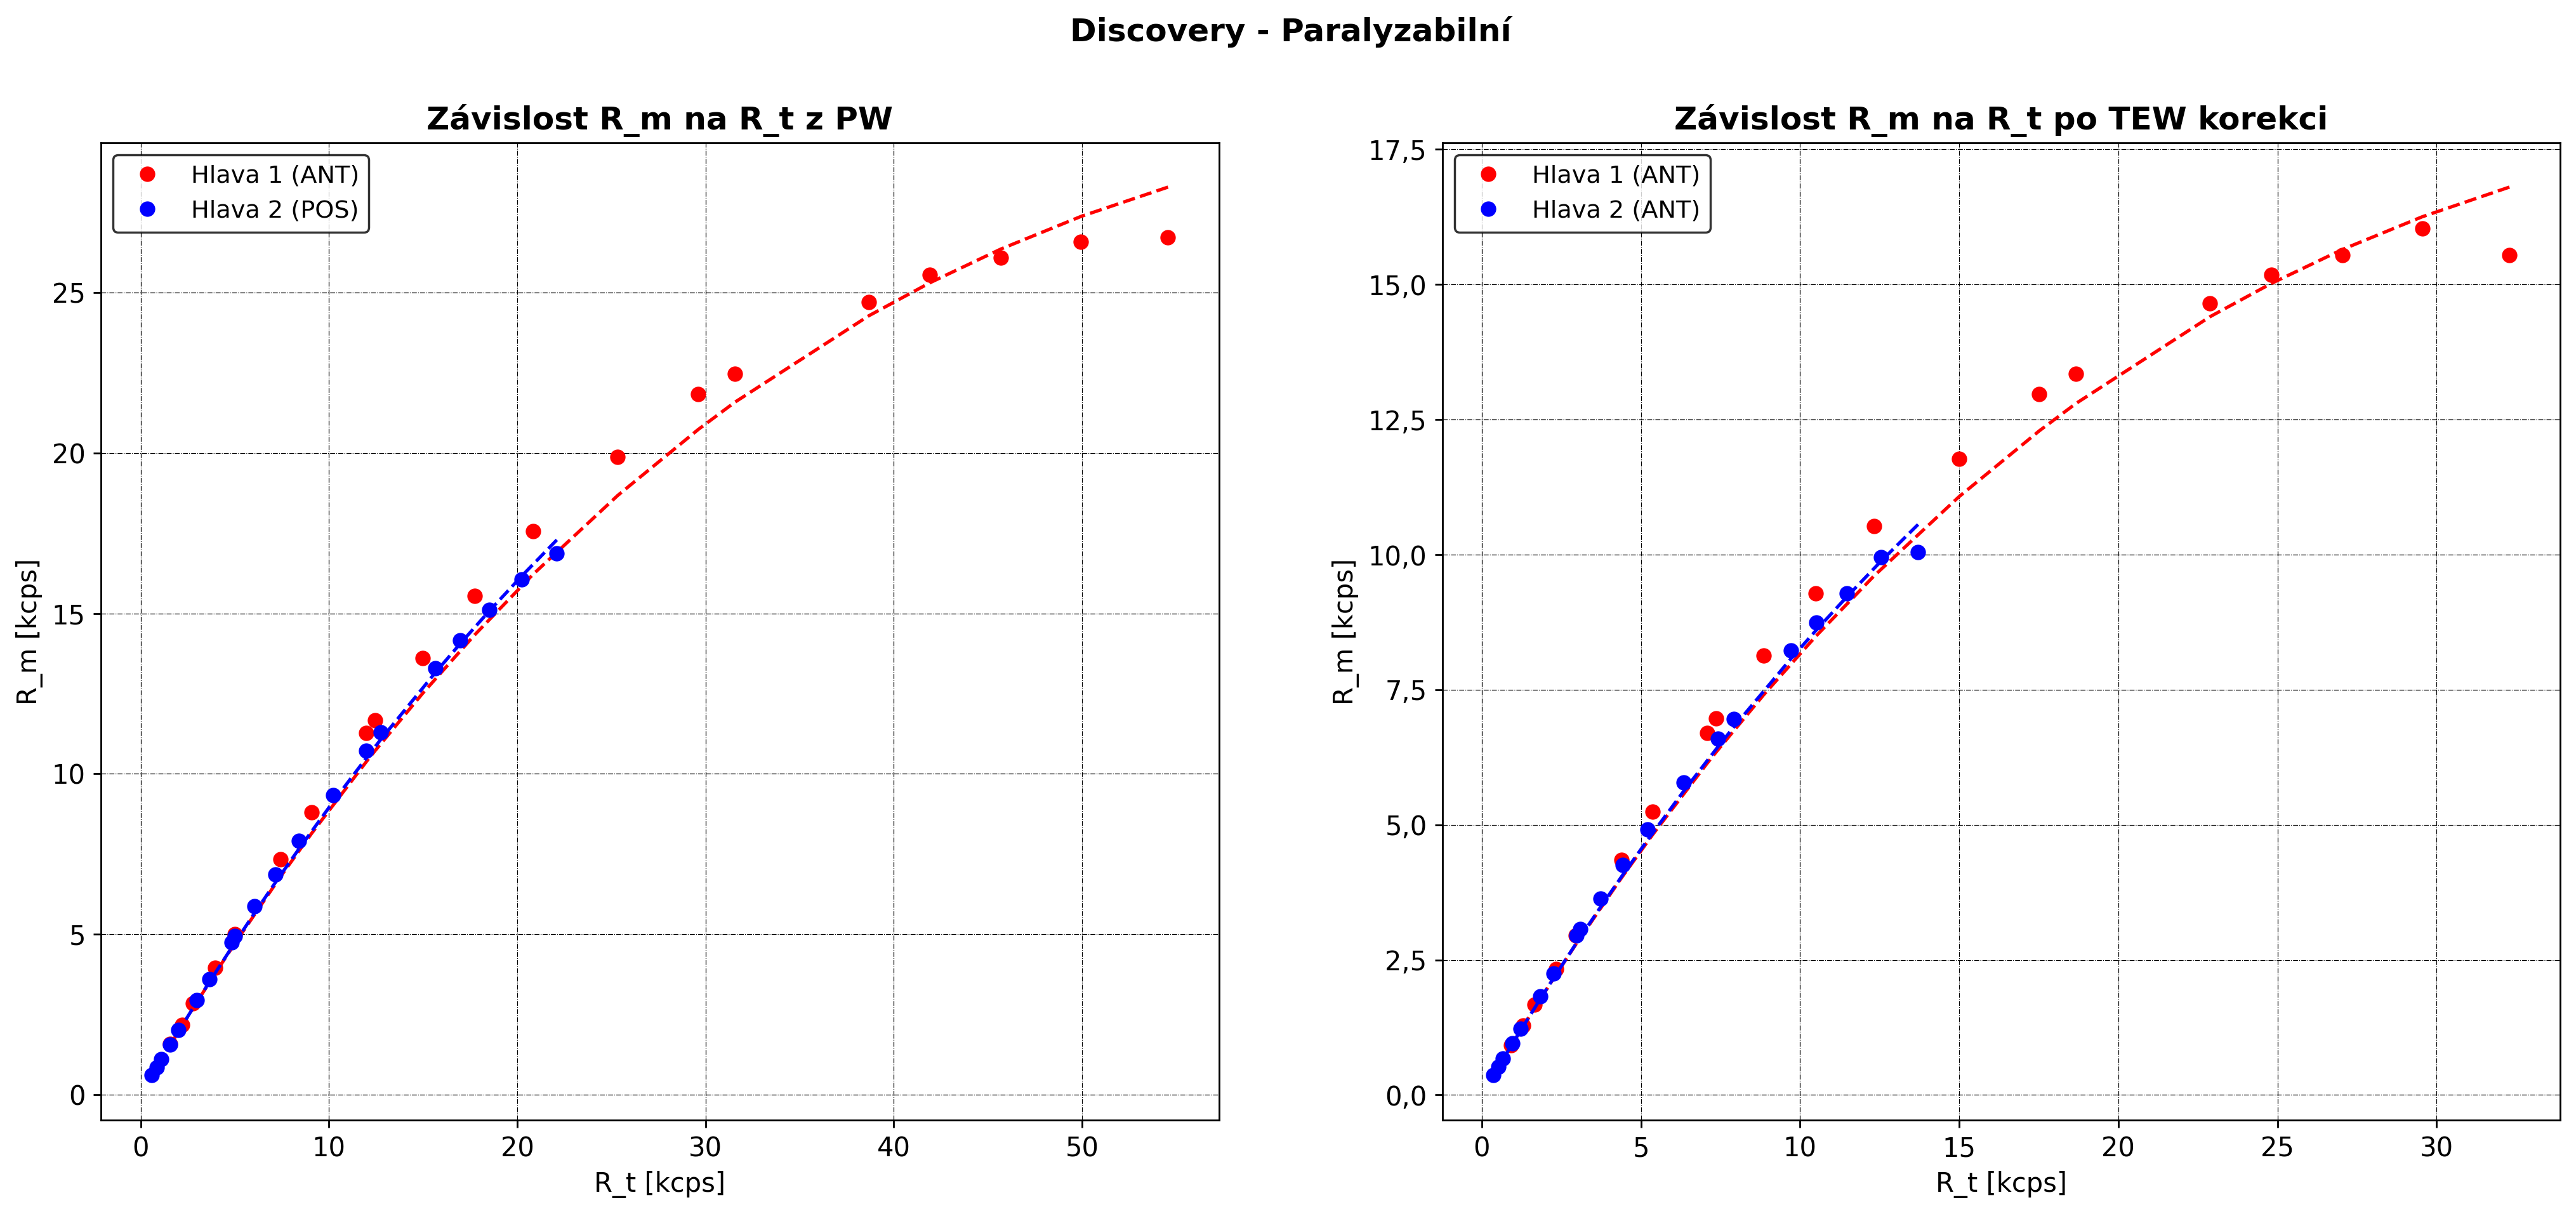

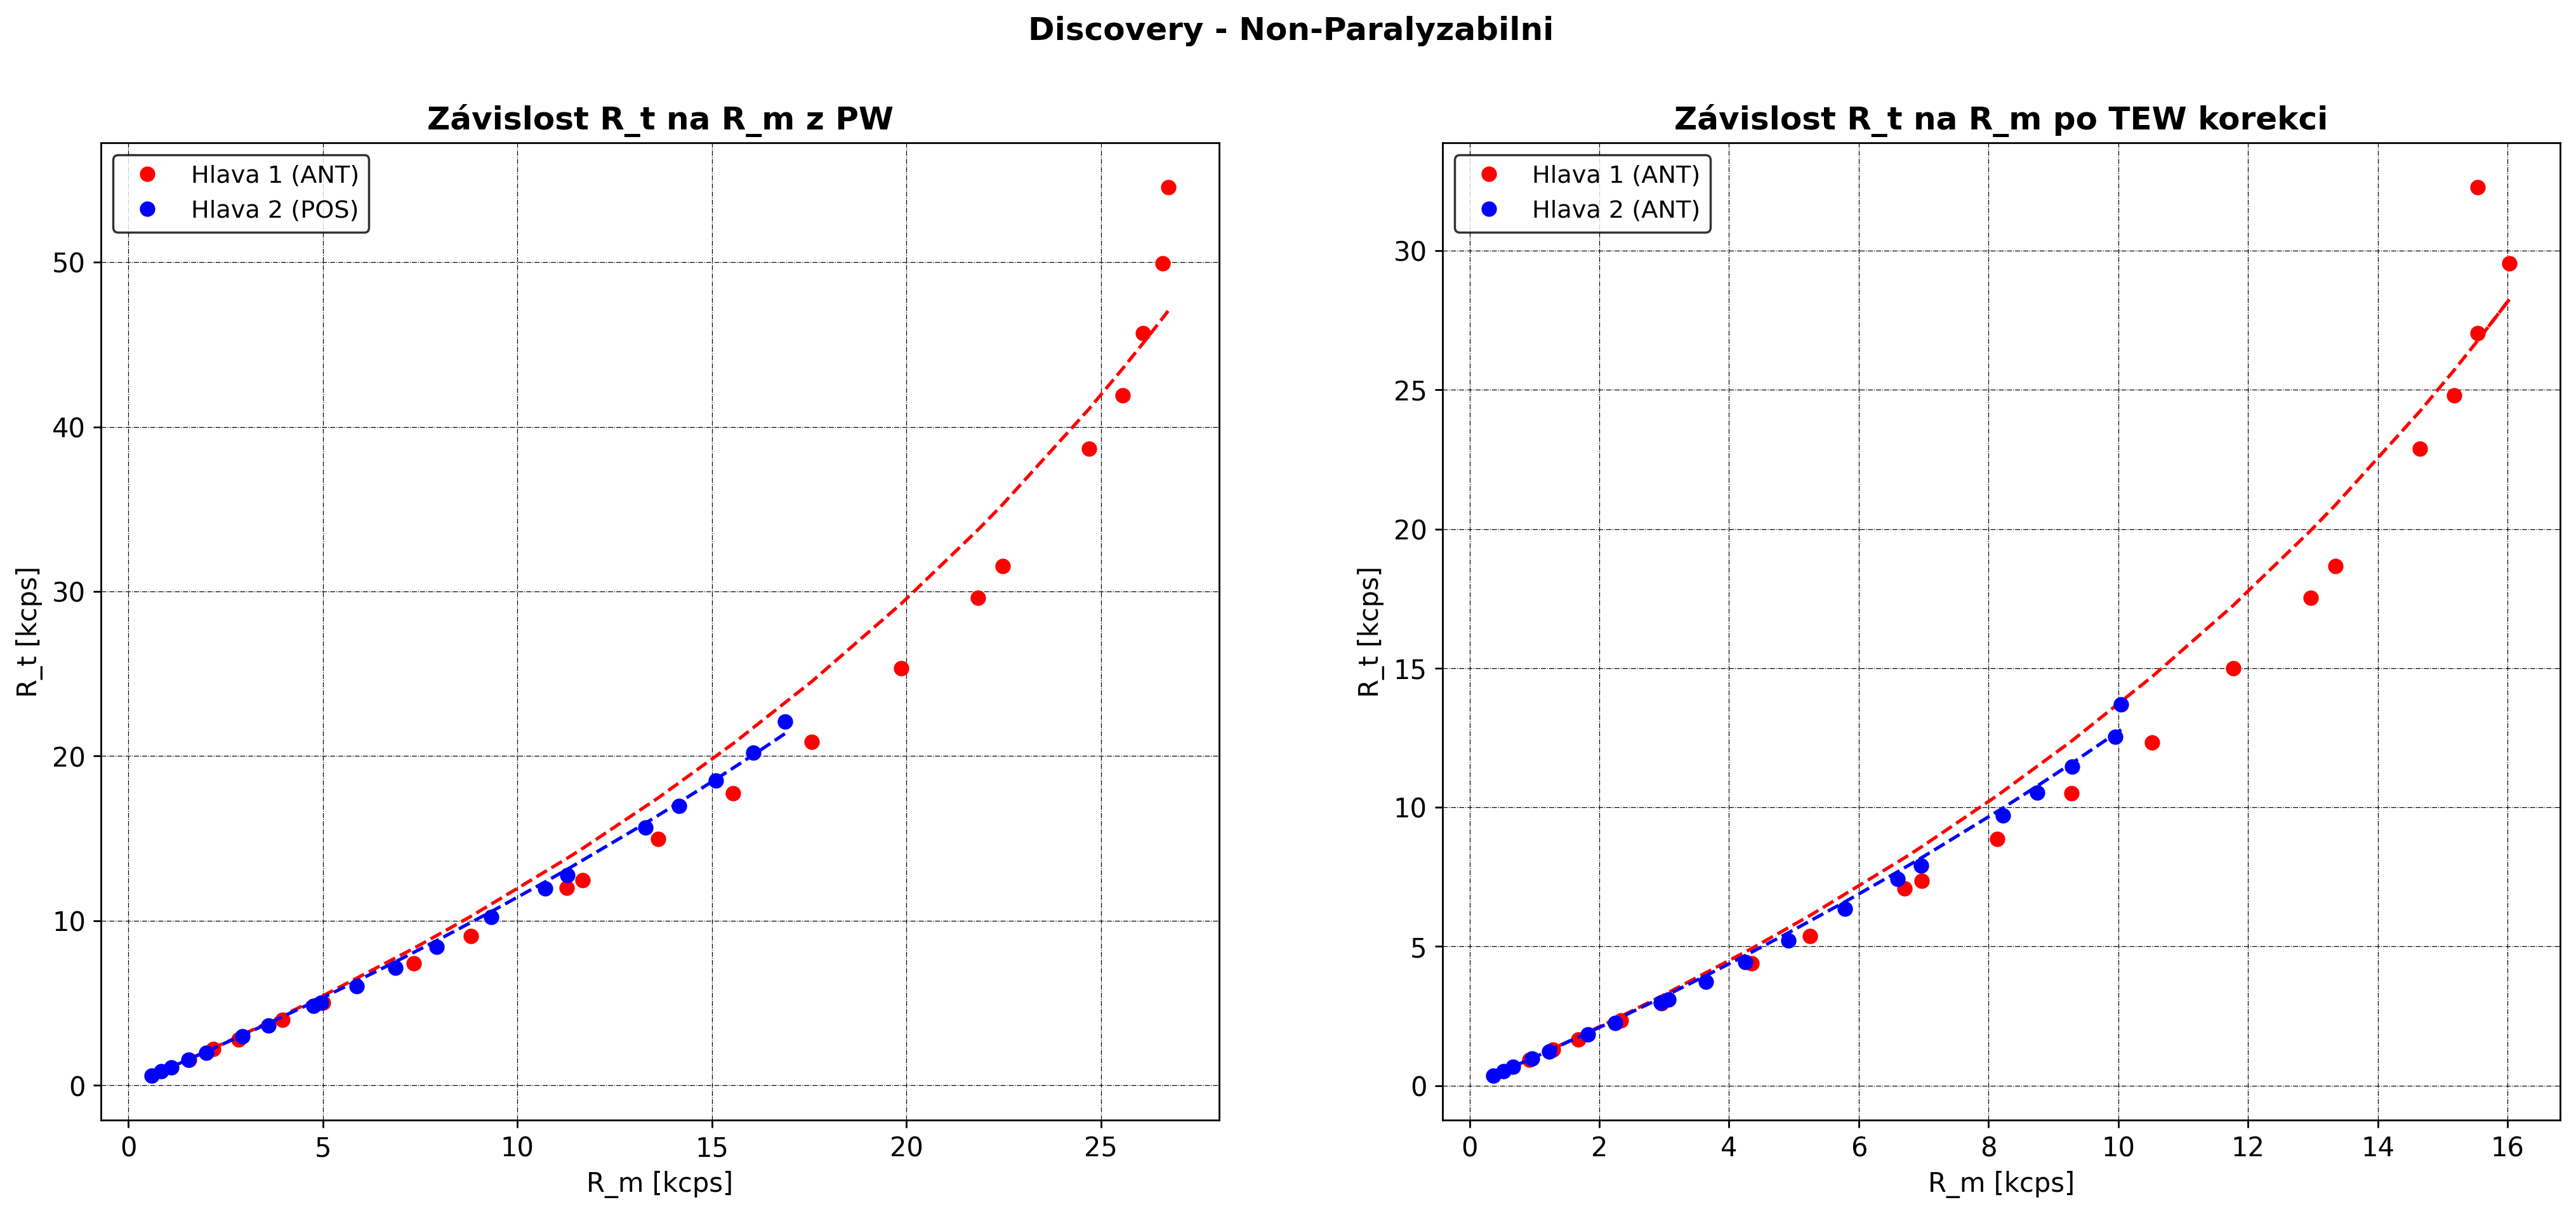

In [15]:
### nalezeni MD Discovery - paralyzabilni

from fitovani import exp_md_fce, exp_md_fit, lomenna_md_fce, lomenny_md_fit

dt_fig_rm_rt = Graf_1_2(12, "Discovery - Paralyzabilní",
               "Závislost R_m na R_t z PW", "R_t [kcps]", "R_m [kcps]",
               "Závislost R_m na R_t po TEW korekci", "R_t [kcps]", "R_m [kcps]",
               (20, 8))

data_pro_lin_fit = [lin_cr_1_no_corr, lin_cr_1_tew_corr, lin_cr_2_no_corr, lin_cr_2_tew_corr]
merene_cps = [cr_1_no_corr_array, cr_1_tew_corr_array, cr_2_no_corr_array, cr_2_tew_corr_array]

akt = np.array(list(aktivity.values()))

i = 0
for data in data_pro_lin_fit:
    fit = linearni_fit(data)
    a = fit[0]
    r_t = linearni_fce(akt,a)
    r_m = merene_cps[i]

    md_fit = exp_md_fit([r_t, r_m])
    tau = md_fit[0]
    if i == 0:
        dt_fig_rm_rt.fig[0].plot(r_t, r_m, "o", color = "red", label = "Hlava 1 (ANT)")
        dt_fig_rm_rt.fig[0].plot(r_t, exp_md_fce(r_t, tau), "--", color = "red")
        print(tau)
        i += 1
    elif i == 1:
        dt_fig_rm_rt.fig[1].plot(r_t, r_m, "o", color = "red", label = "Hlava 1 (ANT)")
        dt_fig_rm_rt.fig[1].plot(r_t, exp_md_fce(r_t, tau), "--", color = "red")
        i += 1
    elif i == 2:
        dt_fig_rm_rt.fig[0].plot(r_t, r_m, "o", color = "blue", label = "Hlava 2 (POS)")
        dt_fig_rm_rt.fig[0].plot(r_t, exp_md_fce(r_t, tau), "--", color = "blue")
        i += 1
    else:
        dt_fig_rm_rt.fig[1].plot(r_t, r_m, "o", color = "blue", label = "Hlava 2 (ANT)")
        dt_fig_rm_rt.fig[1].plot(r_t, exp_md_fce(r_t, tau), "--", color = "blue")
        i += 1

dt_fig_rm_rt.fig[0].legend(loc = 'best', edgecolor = 'black', fontsize = 11)
dt_fig_rm_rt.fig[1].legend(loc = 'best', edgecolor = 'black', fontsize = 11)



### nalezeni MD Discovery - NONparalyzabilni


dt_fig_rm_rt_nonpara = Graf_1_2(12, "Discovery - Non-Paralyzabilni",
               "Závislost R_t na R_m z PW", "R_m [kcps]", "R_t [kcps]",
               "Závislost R_t na R_m po TEW korekci", "R_m [kcps]", "R_t [kcps]",
               (20, 8))

i = 0
for data in data_pro_lin_fit:
    fit = linearni_fit(data)
    a = fit[0]
    r_t = linearni_fce(akt,a)
    r_m = merene_cps[i]

    md_fit = lomenny_md_fit([r_m, r_t])
    tau = md_fit[0]
    if i == 0:
        dt_fig_rm_rt_nonpara.fig[0].plot(r_m, r_t, "o", color = "red", label = "Hlava 1 (ANT)")
        dt_fig_rm_rt_nonpara.fig[0].plot(r_m, lomenna_md_fce(r_m, tau), "--", color = "red")
        print(tau)
        i += 1
    elif i == 1:
        dt_fig_rm_rt_nonpara.fig[1].plot(r_m, r_t, "o", color = "red", label = "Hlava 1 (ANT)")
        dt_fig_rm_rt_nonpara.fig[1].plot(r_m, lomenna_md_fce(r_m, tau), "--", color = "red")
        i += 1
    elif i == 2:
        dt_fig_rm_rt_nonpara.fig[0].plot(r_m, r_t, "o", color = "blue", label = "Hlava 2 (POS)")
        dt_fig_rm_rt_nonpara.fig[0].plot(r_m, lomenna_md_fce(r_m, tau), "--", color = "blue")
        i += 1
    else:
        dt_fig_rm_rt_nonpara.fig[1].plot(r_m, r_t, "o", color = "blue", label = "Hlava 2 (ANT)")
        dt_fig_rm_rt_nonpara.fig[1].plot(r_m, lomenna_md_fce(r_m, tau), "--", color = "blue")
        i += 1

dt_fig_rm_rt_nonpara.fig[0].legend(loc = 'best', edgecolor = 'black', fontsize = 11)
dt_fig_rm_rt_nonpara.fig[1].legend(loc = 'best', edgecolor = 'black', fontsize = 11)


0
1
2
3


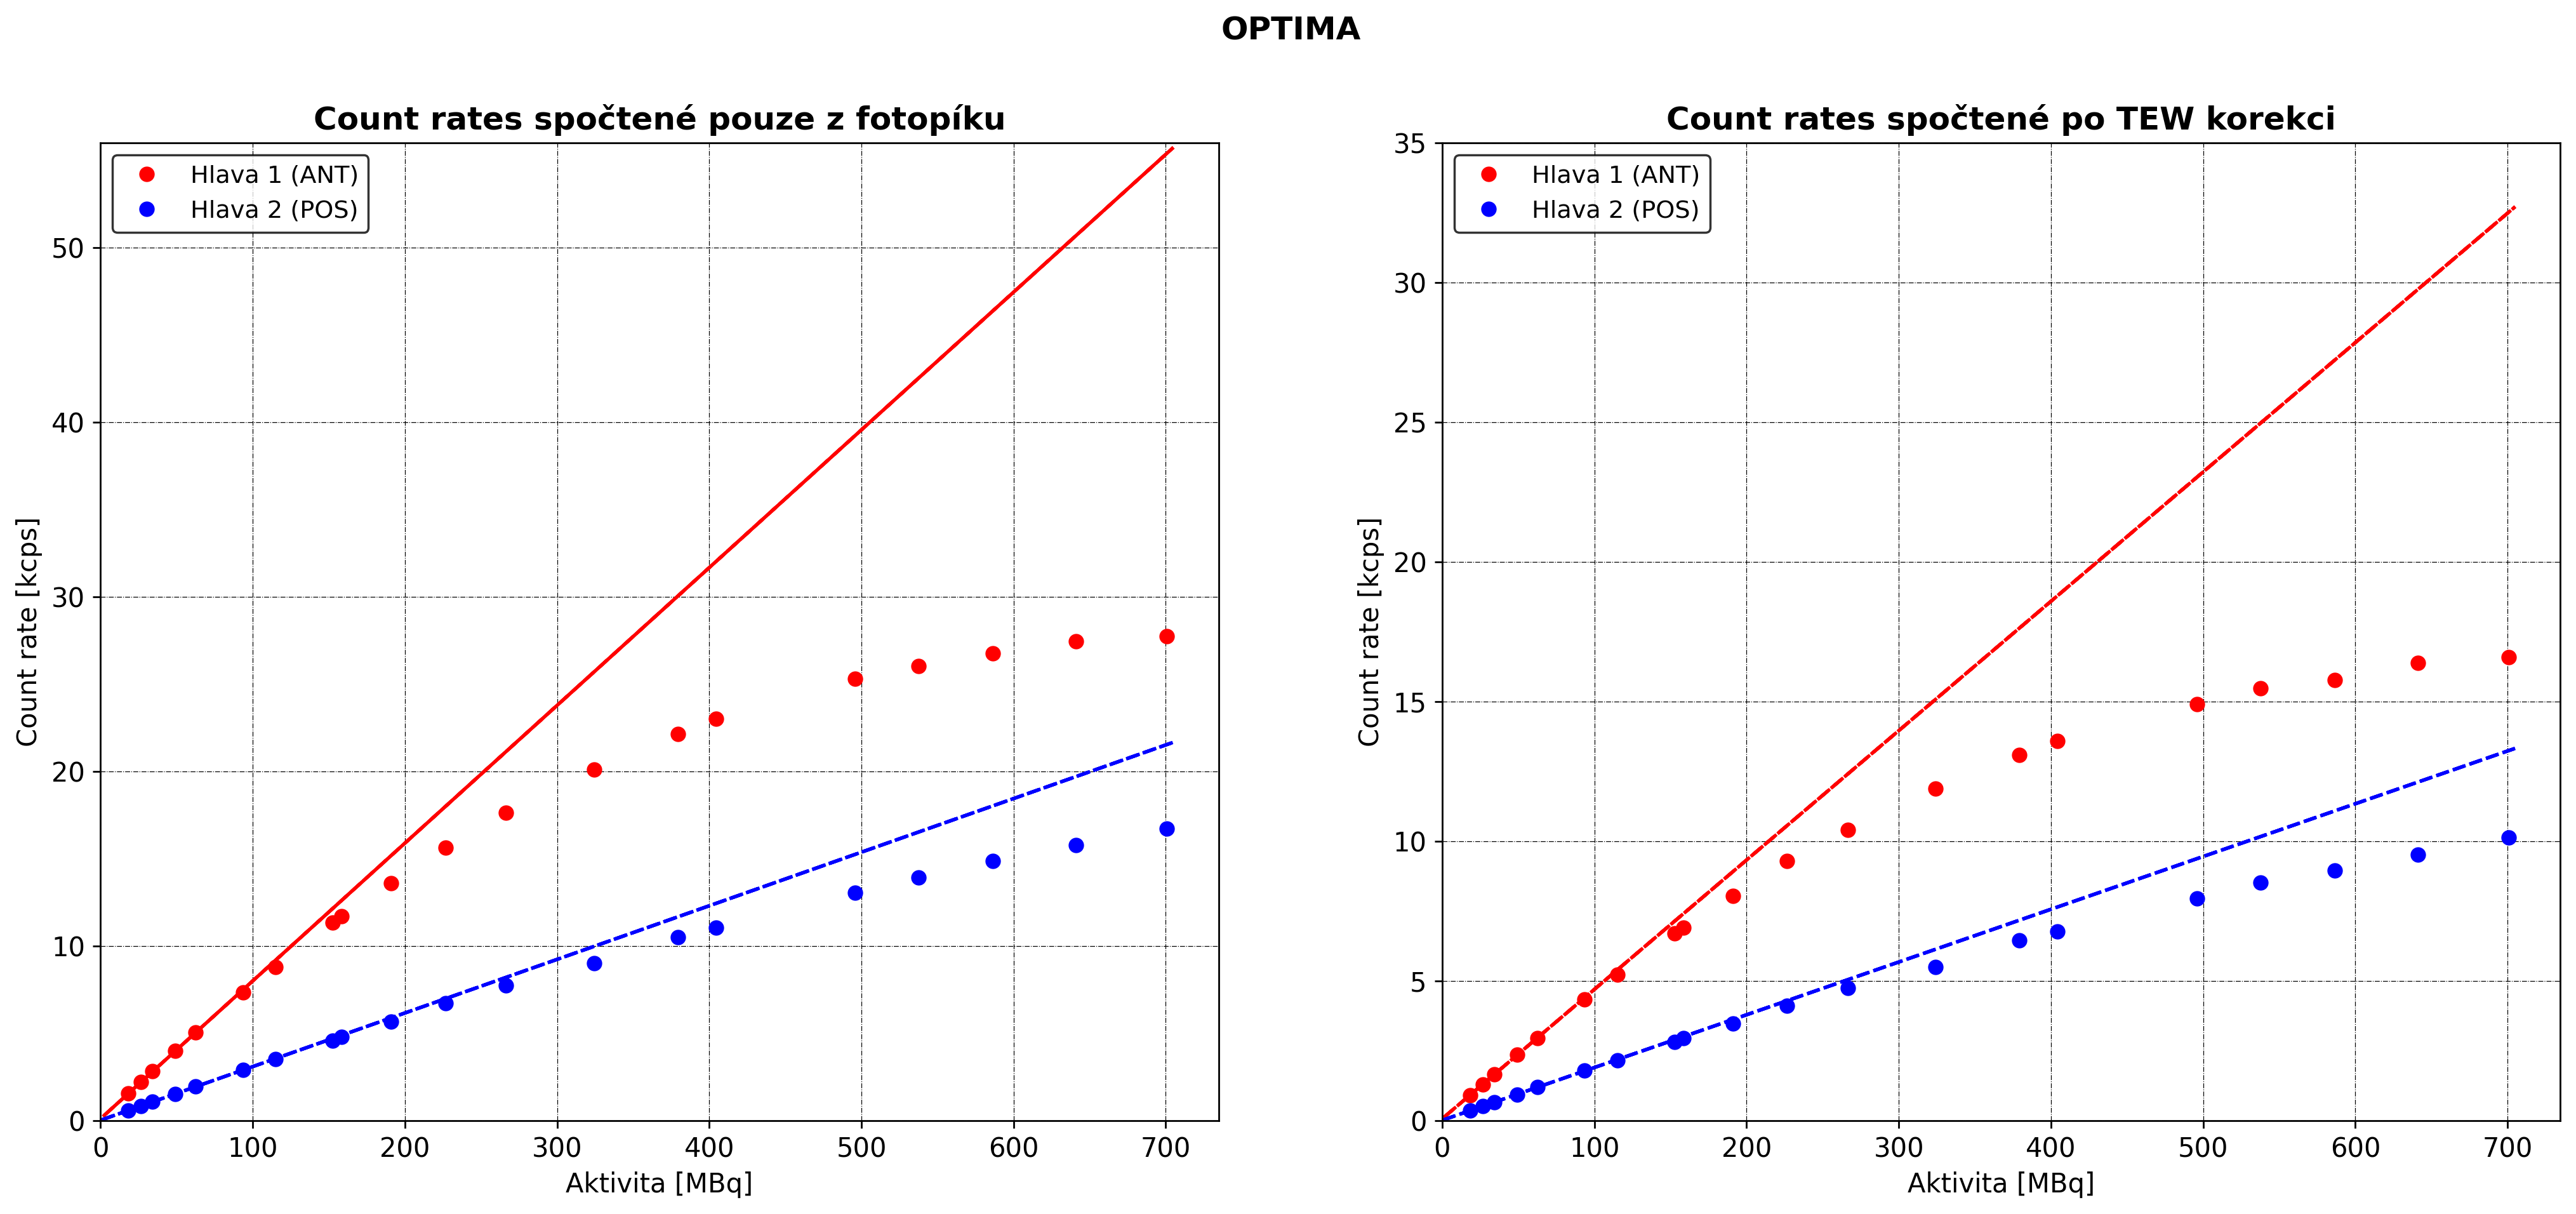

In [16]:
# OPTIMA DATA mrtve doby

from dicom_file_separator import separate_dicom_file
from tew_correction import tew_correction
from vyber_dat_pro_fit import vyber_dat_pro_lin_fit
from fitovani import linearni_fit, linearni_fce
import numpy as np
from lmfit import Model



optima_folder = 'Optima'
optima_mds = sorted(glob(os.path.join(optima_folder, 'MD*')))

# je nutne si preddefinovat obrazek predem
dt_fig = Graf_1_2(12, "OPTIMA",
               "Count rates spočtené pouze z fotopíku", "Aktivita [MBq]", "Count rate [kcps]",
               "Count rates spočtené po TEW korekci", "Aktivita [MBq]", "Count rate [kcps]",
               (20, 8))

# arraye pro doplňování Countrates
cr_1_no_corr_array = []
cr_2_no_corr_array = []
cr_1_tew_corr_array = []
cr_2_tew_corr_array = []

for md in optima_mds:
    ### nejprve rozhazeni jednotlivych dat
    dead_time_path = glob(os.path.join(md, 'MD_*.dcm'))[0]
    pozadi_path = glob(os.path.join(md, 'Pozadi_*.dcm'))[0]

    dt_data = separate_dicom_file(dead_time_path)
    bg_data = separate_dicom_file(pozadi_path)

    dt_acq_time = dt_data["Acq_time"]
    bg_acq_time = bg_data["Acq_time"]
    datum = dt_data["Acq_date"]
    aktivita = aktivity[datum]

    dt_1_no_corr = dt_data["Head1_EM"]
    bg_1_no_corr = bg_data["Head1_EM"]

    dt_1_tew_corr = tew_correction(dt_data["Head1_EM"], dt_data["Head1_SC1"], dt_data["Head1_SC2"])
    bg_1_tew_corr = tew_correction(bg_data["Head1_EM"], bg_data["Head1_SC1"], bg_data["Head1_SC2"])

    dt_2_no_corr = dt_data["Head2_EM"]
    bg_2_no_corr = bg_data["Head2_EM"]
    
    dt_2_tew_corr = tew_correction(dt_data["Head2_EM"], dt_data["Head2_SC1"], dt_data["Head2_SC2"])
    bg_2_tew_corr = tew_correction(bg_data["Head2_EM"], bg_data["Head2_SC1"], bg_data["Head2_SC2"])

    ### ----
    ### vypocty count rates

    cr_1_no_corr = np.sum(dt_1_no_corr)/dt_acq_time - np.sum(bg_1_no_corr)/bg_acq_time
    cr_1_no_corr_array.append(cr_1_no_corr*0.001)

    cr_2_no_corr = np.sum(dt_2_no_corr)/dt_acq_time - np.sum(bg_2_no_corr)/bg_acq_time
    cr_2_no_corr_array.append(cr_2_no_corr*0.001)

    cr_1_tew_corr = np.sum(dt_1_tew_corr)/dt_acq_time - np.sum(bg_1_tew_corr)/bg_acq_time
    cr_1_tew_corr_array.append(cr_1_tew_corr*0.001)

    cr_2_tew_corr = np.sum(dt_2_tew_corr)/dt_acq_time - np.sum(bg_2_tew_corr)/bg_acq_time
    cr_2_tew_corr_array.append(cr_2_tew_corr*0.001)

### ----
### vyploteni do obrazku
dt_fig.fig[0].plot(aktivity.values(), cr_1_no_corr_array, "o", color = "red", label = "Hlava 1 (ANT)")
dt_fig.fig[0].plot(aktivity.values(), cr_2_no_corr_array, "o", color = "blue", label = "Hlava 2 (POS)")
dt_fig.fig[0].legend(loc = 'best', edgecolor = 'black', fontsize = 11)
dt_fig.fig[0].set_xlim(0,None)
dt_fig.fig[0].set_ylim(0,56)

dt_fig.fig[1].plot(aktivity.values(), cr_1_tew_corr_array, "o", color = "red", label = "Hlava 1 (ANT)")
dt_fig.fig[1].plot(aktivity.values(), cr_2_tew_corr_array, "o", color = "blue", label = "Hlava 2 (POS)")
dt_fig.fig[1].legend(loc = 'best', edgecolor = 'black', fontsize = 11)
dt_fig.fig[1].set_xlim(0,None)
dt_fig.fig[1].set_ylim(0,35)


lin_cr_1_no_corr = vyber_dat_pro_lin_fit(aktivity.values(), cr_1_no_corr_array)
lin_cr_1_tew_corr = vyber_dat_pro_lin_fit(aktivity.values(), cr_1_tew_corr_array)
lin_cr_2_no_corr = vyber_dat_pro_lin_fit(aktivity.values(), cr_2_no_corr_array)
lin_cr_2_tew_corr = vyber_dat_pro_lin_fit(aktivity.values(), cr_2_tew_corr_array)

data_pro_lin_fit = [lin_cr_1_no_corr, lin_cr_1_tew_corr, lin_cr_2_no_corr, lin_cr_2_tew_corr]
i = 0
for data in data_pro_lin_fit:
    akt = np.linspace(data[-1],705,5)
    fit = linearni_fit(data)
    a = fit[0]
    if i == 0:
        dt_fig.fig[0].plot(akt, linearni_fce(akt,a), "--", color = "red")
        i += 1
    elif i == 1:
        dt_fig.fig[1].plot(akt, linearni_fce(akt,a), "--", color = "red")
        i += 1
    elif i == 2:
        dt_fig.fig[0].plot(akt, linearni_fce(akt,a), "--", color = "blue")
        i += 1
    else:
        dt_fig.fig[1].plot(akt, linearni_fce(akt,a), "--", color = "blue")
        i += 1
    
dt_fig.Figure.savefig(os.path.join(optima_folder, 'grafy_mrtve_doby_Optima.jpg'), bbox_inches = "tight")

0.01162807204837131
0.015544584043631187


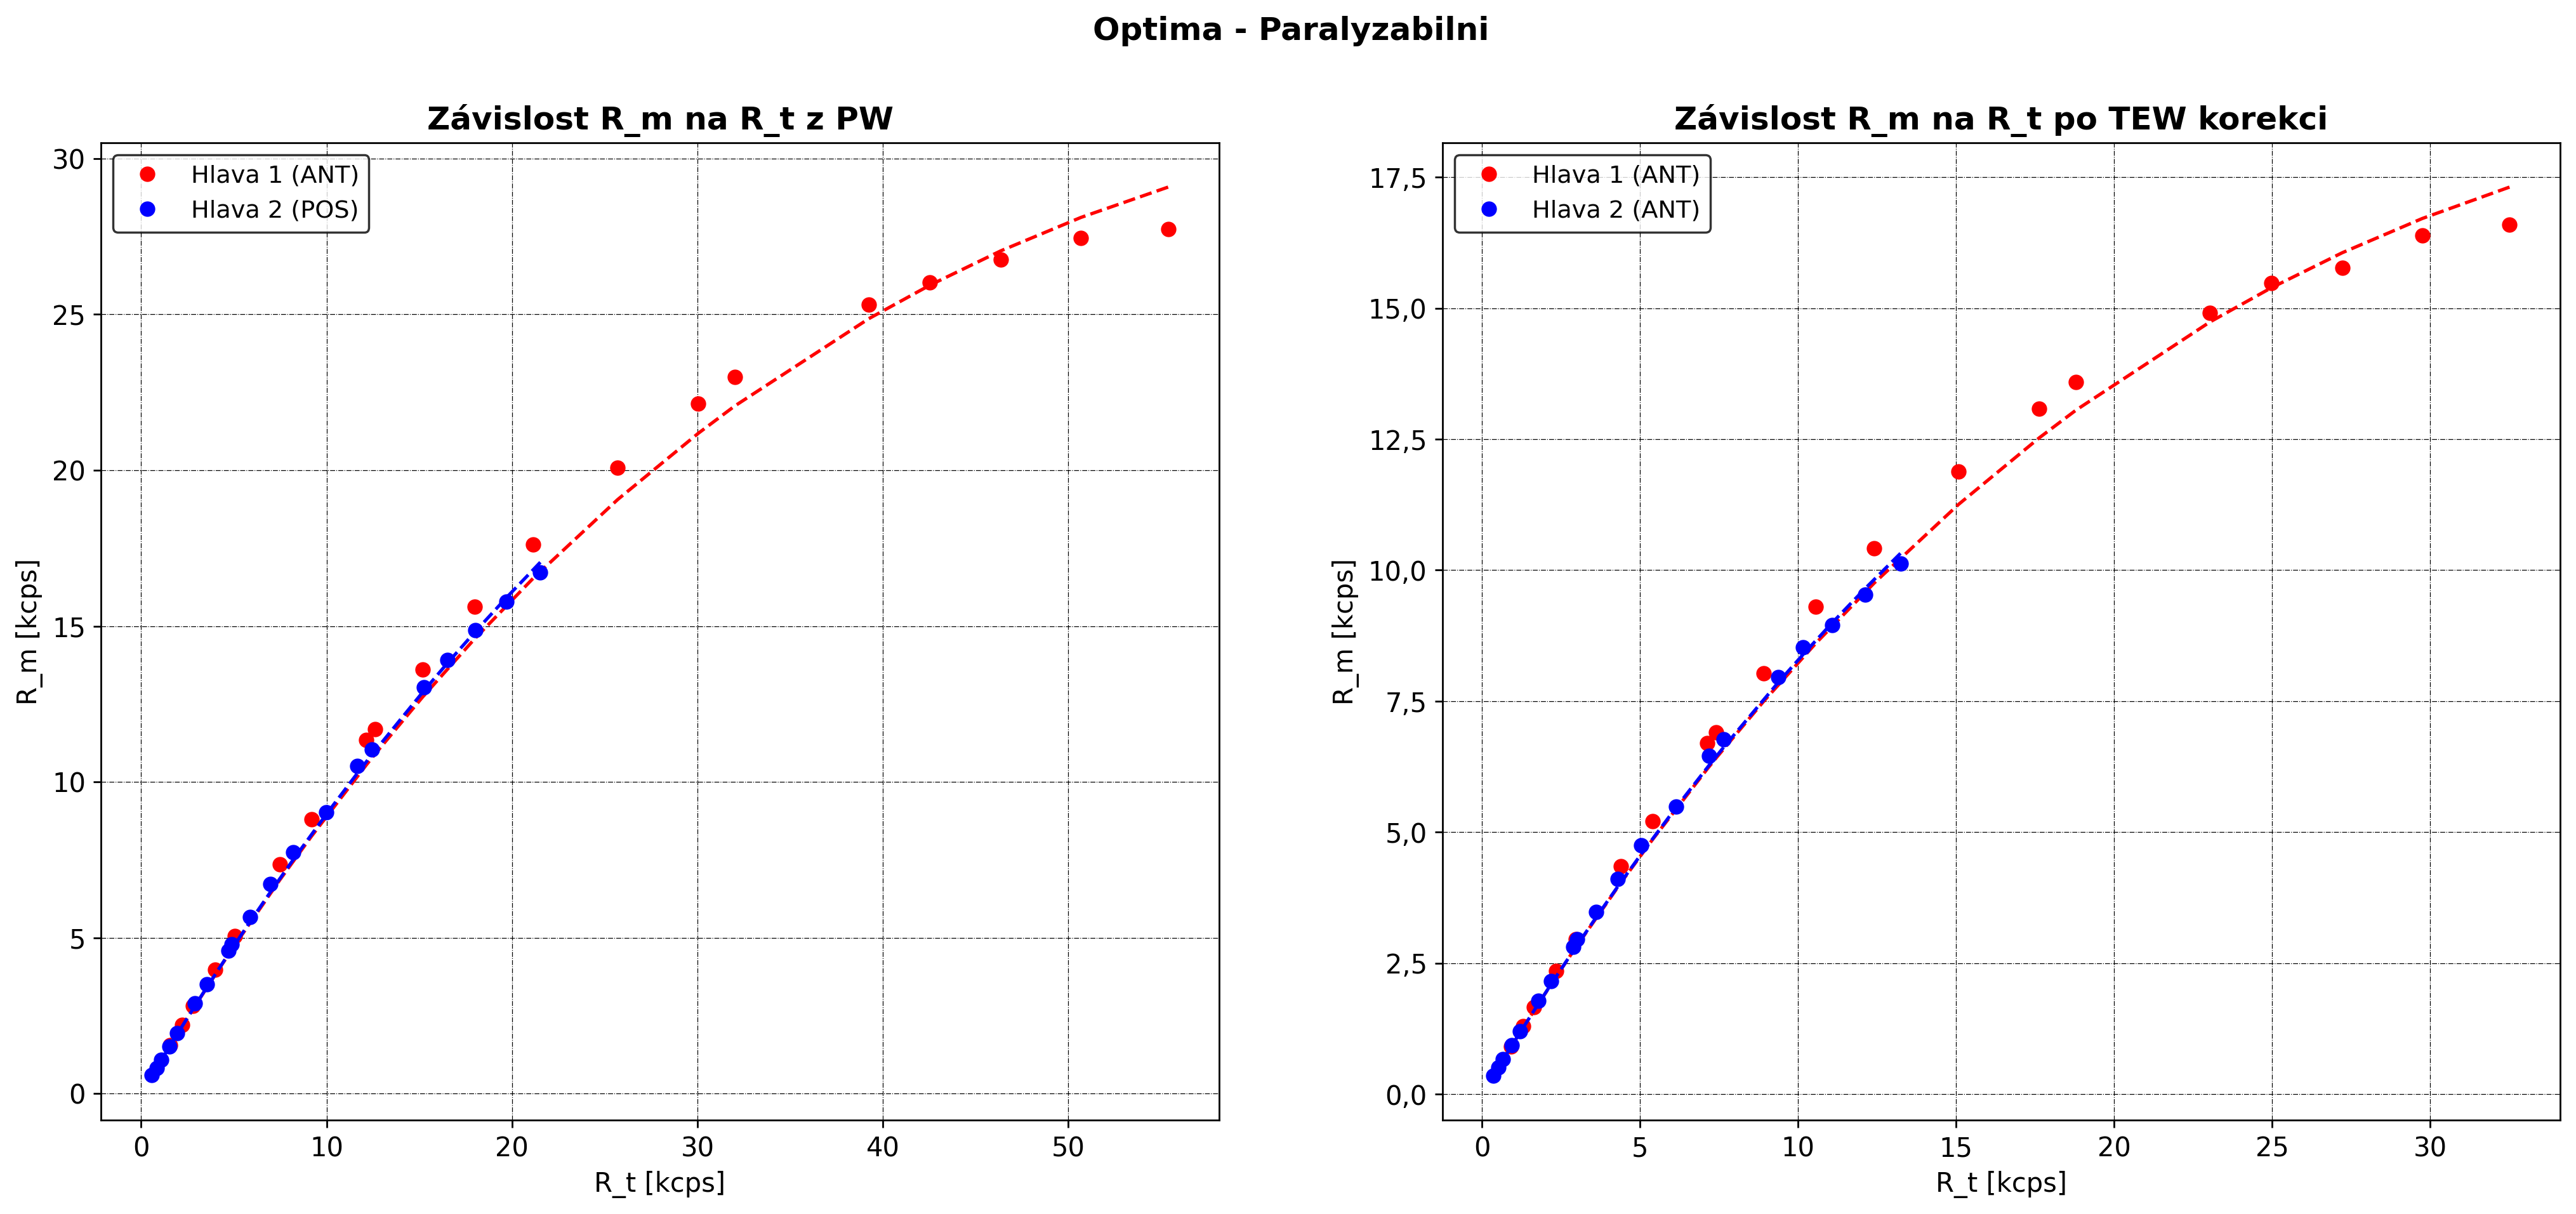

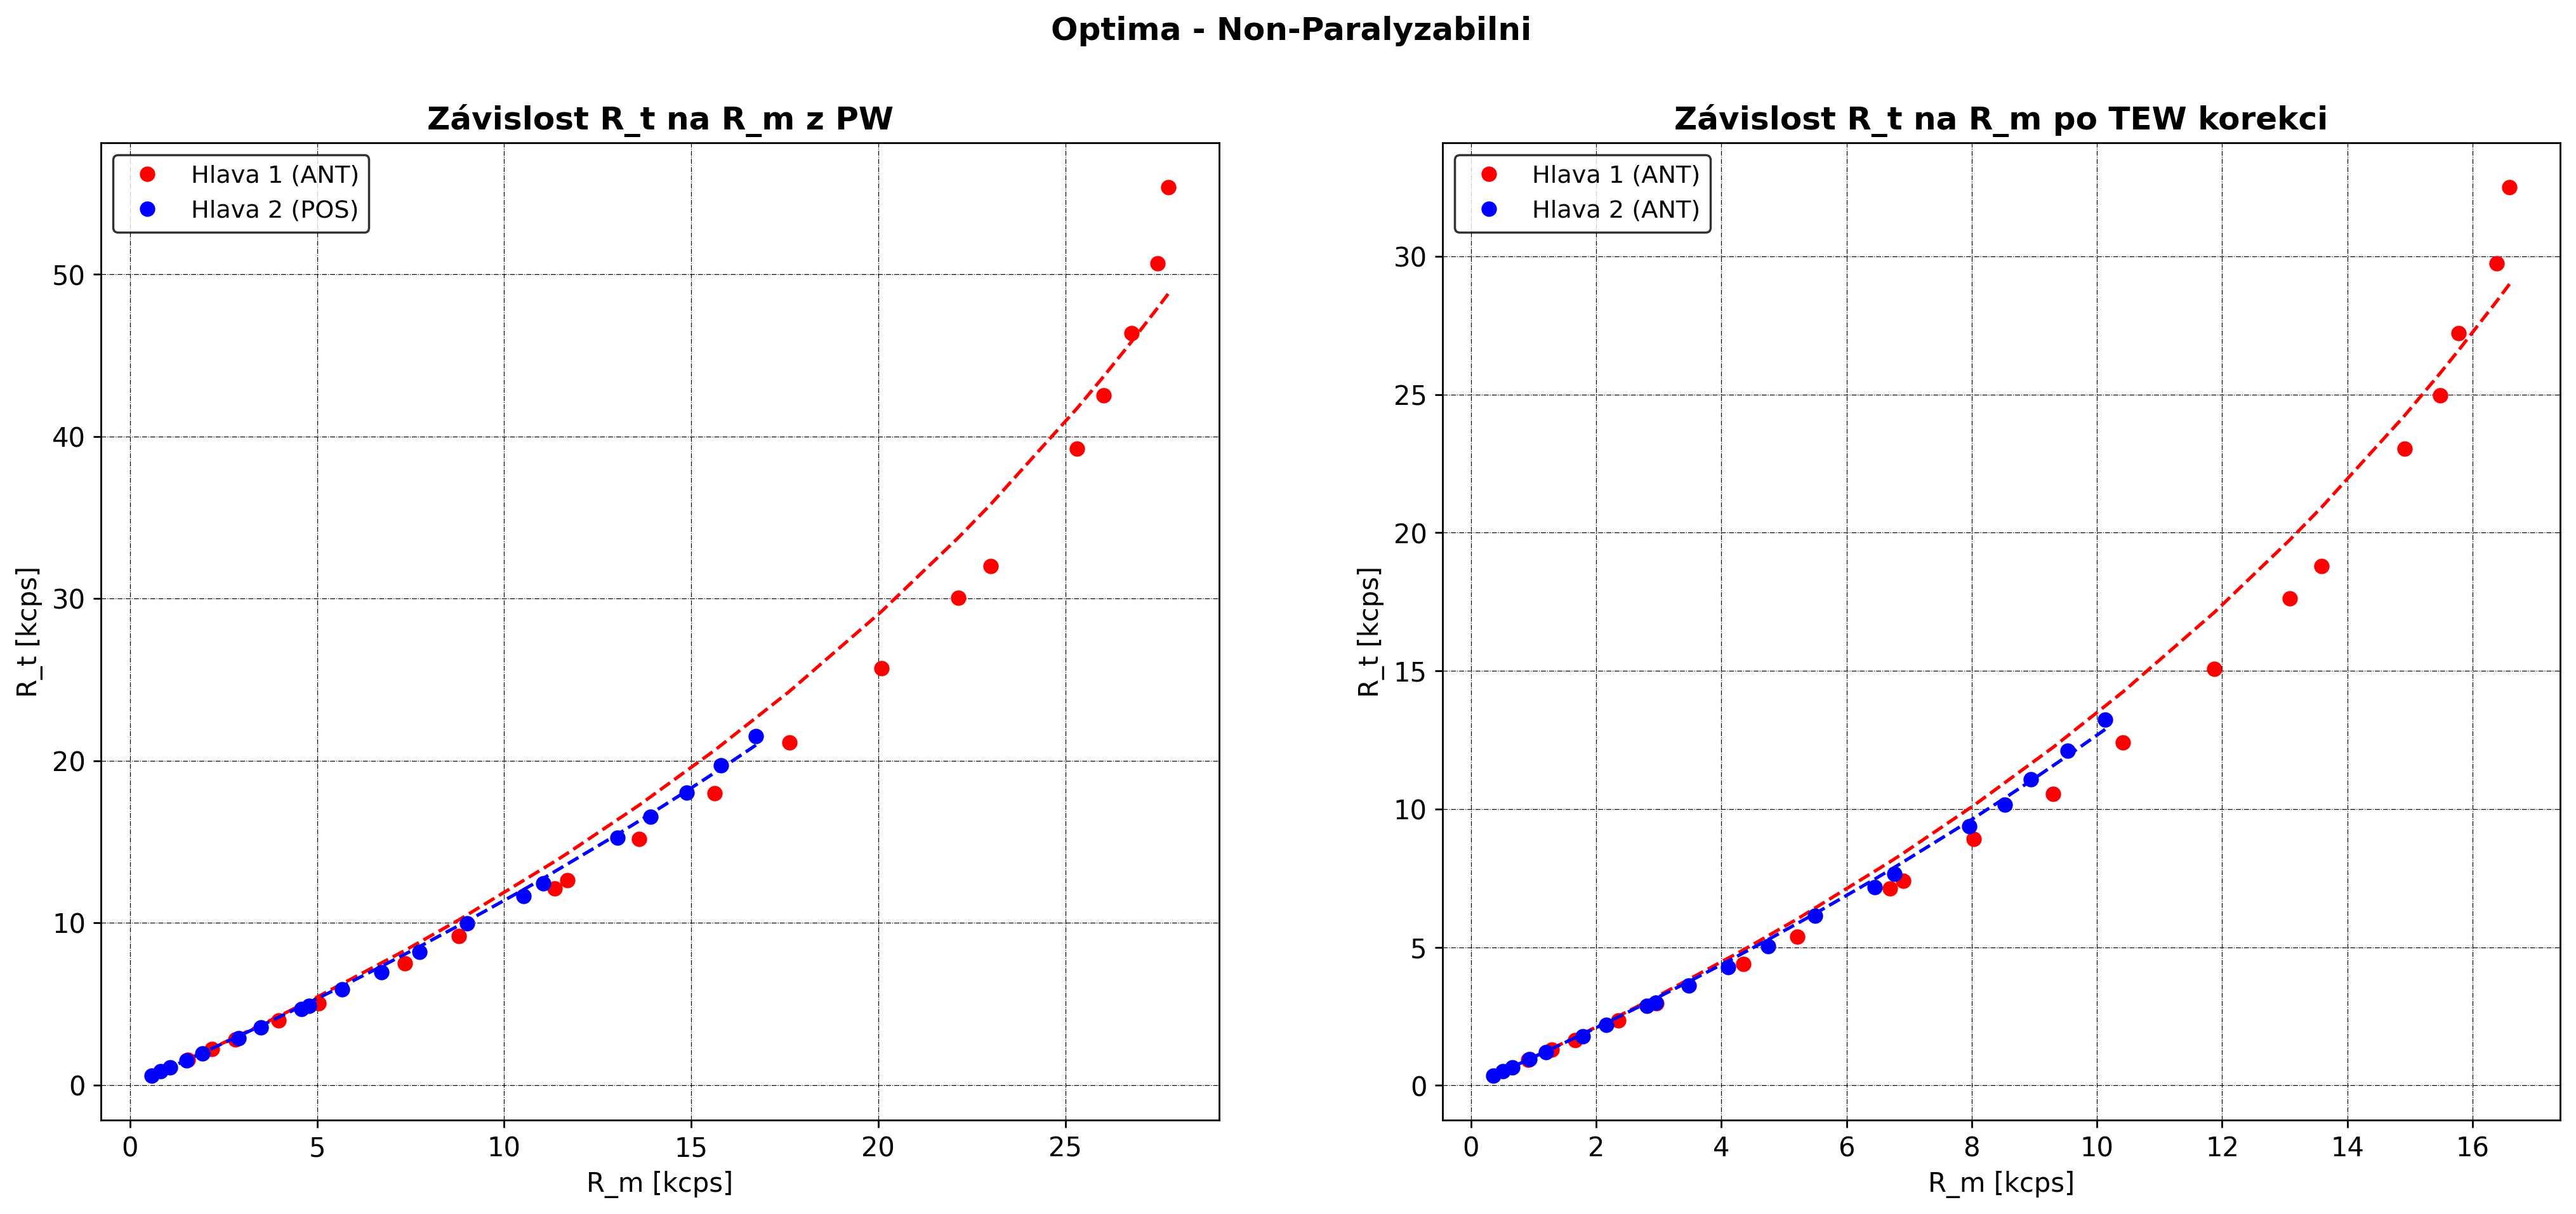

In [17]:
### nalezeni MD Optima - paralyzabilni

from fitovani import exp_md_fce, exp_md_fit, lomenna_md_fce, lomenny_md_fit

dt_fig_rm_rt = Graf_1_2(12, "Optima - Paralyzabilni",
               "Závislost R_m na R_t z PW", "R_t [kcps]", "R_m [kcps]",
               "Závislost R_m na R_t po TEW korekci", "R_t [kcps]", "R_m [kcps]",
               (20, 8))

data_pro_lin_fit = [lin_cr_1_no_corr, lin_cr_1_tew_corr, lin_cr_2_no_corr, lin_cr_2_tew_corr]
merene_cps = [cr_1_no_corr_array, cr_1_tew_corr_array, cr_2_no_corr_array, cr_2_tew_corr_array]

akt = np.array(list(aktivity.values()))

i = 0
for data in data_pro_lin_fit:
    fit = linearni_fit(data)
    a = fit[0]
    r_t = linearni_fce(akt,a)
    r_m = merene_cps[i]

    md_fit = exp_md_fit([r_t, r_m])
    tau = md_fit[0]
    if i == 0:
        dt_fig_rm_rt.fig[0].plot(r_t, r_m, "o", color = "red", label = "Hlava 1 (ANT)")
        dt_fig_rm_rt.fig[0].plot(r_t, exp_md_fce(r_t, tau), "--", color = "red")
        print(tau)
        i += 1
    elif i == 1:
        dt_fig_rm_rt.fig[1].plot(r_t, r_m, "o", color = "red", label = "Hlava 1 (ANT)")
        dt_fig_rm_rt.fig[1].plot(r_t, exp_md_fce(r_t, tau), "--", color = "red")
        i += 1
    elif i == 2:
        dt_fig_rm_rt.fig[0].plot(r_t, r_m, "o", color = "blue", label = "Hlava 2 (POS)")
        dt_fig_rm_rt.fig[0].plot(r_t, exp_md_fce(r_t, tau), "--", color = "blue")
        i += 1
    else:
        dt_fig_rm_rt.fig[1].plot(r_t, r_m, "o", color = "blue", label = "Hlava 2 (ANT)")
        dt_fig_rm_rt.fig[1].plot(r_t, exp_md_fce(r_t, tau), "--", color = "blue")
        i += 1

dt_fig_rm_rt.fig[0].legend(loc = 'best', edgecolor = 'black', fontsize = 11)
dt_fig_rm_rt.fig[1].legend(loc = 'best', edgecolor = 'black', fontsize = 11)


### nalezeni MD Optima - NONparalyzabilni

dt_fig_rm_rt_nonpara = Graf_1_2(12, "Optima - Non-Paralyzabilni",
               "Závislost R_t na R_m z PW", "R_m [kcps]", "R_t [kcps]",
               "Závislost R_t na R_m po TEW korekci", "R_m [kcps]", "R_t [kcps]",
               (20, 8))

i = 0
for data in data_pro_lin_fit:
    fit = linearni_fit(data)
    a = fit[0]
    r_t = linearni_fce(akt,a)
    r_m = merene_cps[i]

    md_fit = lomenny_md_fit([r_m, r_t])
    tau = md_fit[0]
    if i == 0:
        dt_fig_rm_rt_nonpara.fig[0].plot(r_m, r_t, "o", color = "red", label = "Hlava 1 (ANT)")
        dt_fig_rm_rt_nonpara.fig[0].plot(r_m, lomenna_md_fce(r_m, tau), "--", color = "red")
        print(tau)
        i += 1
    elif i == 1:
        dt_fig_rm_rt_nonpara.fig[1].plot(r_m, r_t, "o", color = "red", label = "Hlava 1 (ANT)")
        dt_fig_rm_rt_nonpara.fig[1].plot(r_m, lomenna_md_fce(r_m, tau), "--", color = "red")
        i += 1
    elif i == 2:
        dt_fig_rm_rt_nonpara.fig[0].plot(r_m, r_t, "o", color = "blue", label = "Hlava 2 (POS)")
        dt_fig_rm_rt_nonpara.fig[0].plot(r_m, lomenna_md_fce(r_m, tau), "--", color = "blue")
        i += 1
    else:
        dt_fig_rm_rt_nonpara.fig[1].plot(r_m, r_t, "o", color = "blue", label = "Hlava 2 (ANT)")
        dt_fig_rm_rt_nonpara.fig[1].plot(r_m, lomenna_md_fce(r_m, tau), "--", color = "blue")
        i += 1

dt_fig_rm_rt_nonpara.fig[0].legend(loc = 'best', edgecolor = 'black', fontsize = 11)
dt_fig_rm_rt_nonpara.fig[1].legend(loc = 'best', edgecolor = 'black', fontsize = 11)